In [99]:
from sklearn.cluster import DBSCAN
from imutils import build_montages
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [100]:
print("[INFO] Loading face encodings...")
data = pickle.loads(open("encodings.pickle", "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]

[INFO] Loading face encodings...


In [101]:
n_components_values = list(range(1, min(len(encodings[0]), len(encodings)) + 1))

explained_variances = []

for n_component in n_components_values:
    pca = PCA(n_components=n_component)
    pca.fit(encodings)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

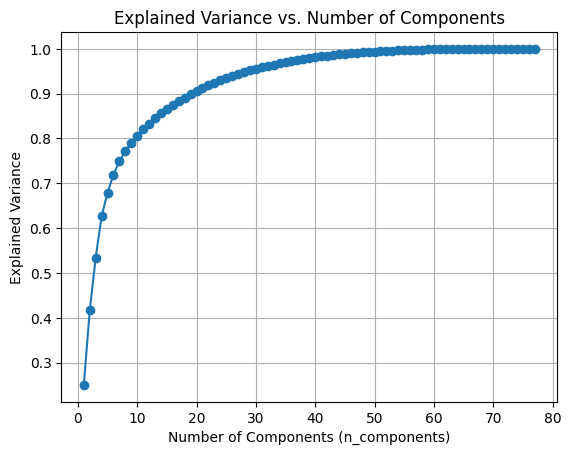

In [102]:
plt.plot(n_components_values, explained_variances, marker='o')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [104]:
for i, ev in enumerate(explained_variances):
    if (0.8 < ev < 0.9):
        print(i, ":", "%.2f" % ev, end=", ")

9 : 0.81, 10 : 0.82, 11 : 0.83, 12 : 0.84, 13 : 0.86, 14 : 0.87, 15 : 0.87, 16 : 0.88, 17 : 0.89, 18 : 0.90, 

In [105]:
pca = PCA(n_components=12)
reduced_data = pca.fit_transform(encodings)

In [106]:
# cluster the embeddings
print("[INFO] Clustering using DBSCAN...")
clt = DBSCAN(eps=0.36, min_samples=6, metric="euclidean", n_jobs=-1)
clt.fit(reduced_data)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
# print(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] Number of unique faces: {}".format(numUniqueFaces))

[INFO] Clustering using DBSCAN...
[INFO] Number of unique faces: 6


[INFO] Faces for face ID: -1


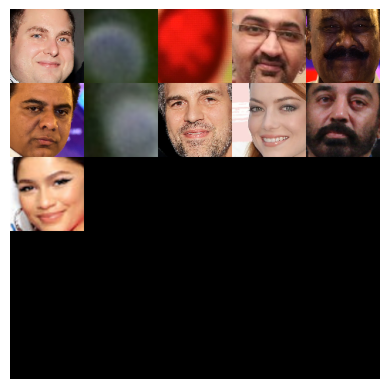

[INFO] Faces for face ID: 0


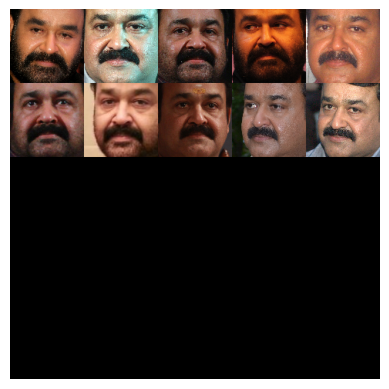

[INFO] Faces for face ID: 1


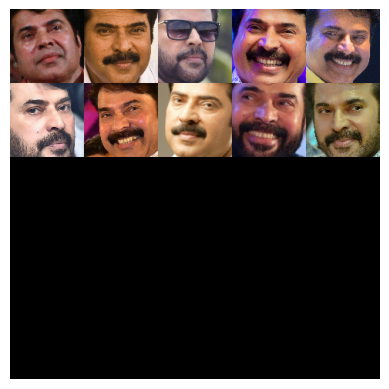

[INFO] Faces for face ID: 2


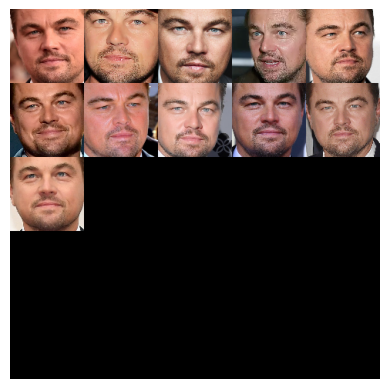

[INFO] Faces for face ID: 3


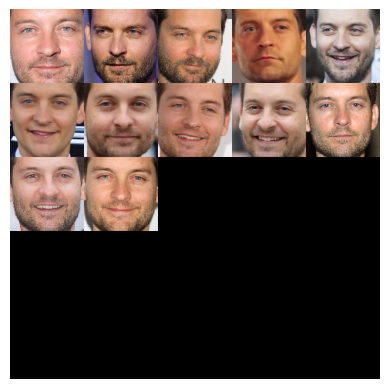

[INFO] Faces for face ID: 4


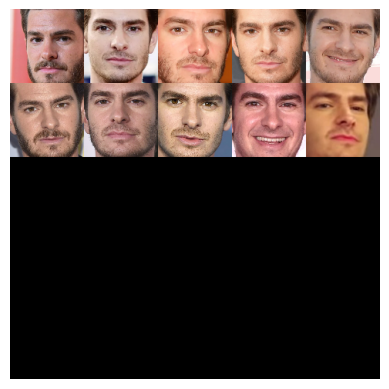

[INFO] Faces for face ID: 5


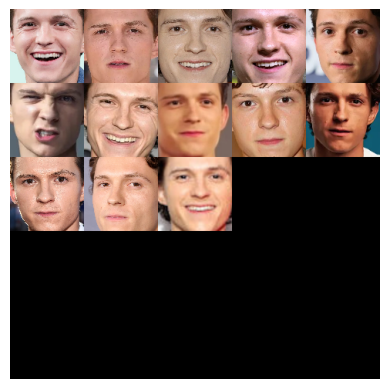

In [107]:
# loop over the unique face integers
for labelID in labelIDs:
	# find all indexes into the `data` array that belong to the
	# current label ID, then randomly sample a maximum of 25 indexes
	# from the set
	print("[INFO] Faces for face ID: {}".format(labelID))
	idxs = np.where(clt.labels_ == labelID)[0]
	idxs = np.random.choice(idxs, size=min(25, len(idxs)),
		replace=False)
	# initialize the list of faces to include in the montage
	faces = []
	
    # loop over the sampled indexes
	for i in idxs:
		# load the input image and extract the face ROI
		image = cv2.imread(data[i]["imagePath"])
		(top, right, bottom, left) = data[i]["loc"]
		face = image[top:bottom, left:right]
		# force resize the face ROI to 96x96 and then add it to the
		# faces montage list
		face = cv2.resize(face, (96, 96))
		faces.append(face)
		
        	# create a montage using 96x96 "tiles" with 5 rows and 5 columns
	montage = build_montages(faces, (96, 96), (5, 5))[0]
	rgb_image = cv2.cvtColor(montage, cv2.COLOR_BGR2RGB)
	
	# show the output montage
	title = "Face ID #{}".format(labelID)
	title = "Unknown Faces" if labelID == -1 else title
	plt.imshow(rgb_image)
	plt.axis('off')  # Optional: Turn off the axis labels
	plt.show()
		

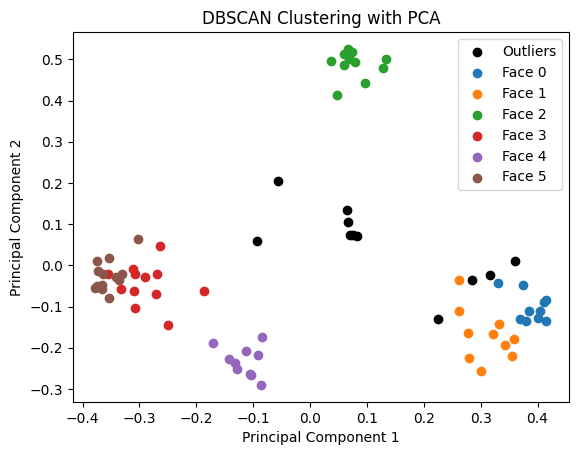

In [108]:
for label in labelIDs:
    if label == -1:
        plt.scatter(reduced_data[clt.labels_ == label, 0], reduced_data[clt.labels_ == label, 1], color='black', label='Outliers')
    else:
        plt.scatter(reduced_data[clt.labels_ == label, 0], reduced_data[clt.labels_ == label, 1], label=f'Face {label}')

plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering with PCA')
plt.show()
